# import libraries

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torchvision import models
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,f1_score
from custom_CNN import CustomCNN
import psutil

torch.Size([1, 10])


# training and testing functions

In [2]:
import time

def train_model(model,device,train_loader, learning_rate, num_epochs):
    # Print training details
    batch_size = train_loader.batch_size
    print(f"Batch Size: {batch_size}")
    print(f"Number of Epochs: {num_epochs}")
    print(f"Learning Rate (starting): {learning_rate}")

    # Modify the model's final layer
    model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward propagation
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print loss per epoch
        print(f"Epoch: [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")
    # Calculate latency for a single sample
    # model.eval() 
    # with torch.no_grad():
    #     start_time = time.time()
    #     for images, _ in train_loader:
    #         images = images.to(device)
    #         # Simulate processing a single sample
    #         for i in range(images.size(0)):
    #             _ = model(images[i].unsqueeze(0))
    #         break  # Measure for one batch
    #     end_time = time.time()
    
    # checkpoint_path = f'model-{batch_size}-{epoch}-{str(learning_rate)}.pth'

    # # Create a dictionary containing the model and optimizer state_dict
    # checkpoint = {
    #     'model_state_dict': model.state_dict(),
    #     'optimizer_state_dict': optimizer.state_dict()
    # }

    # # Save the checkpoint
    # torch.save(checkpoint, checkpoint_path)
    # # Latency per sample
    # latency_per_sample = (end_time - start_time) / images.size(0)
    # print(f"Latency per sample: {latency_per_sample * 1000:.2f} ms")
    # return latency_per_sample * 1000


def measure_latency_cpu_usage(model, test_inputs):
    process = psutil.Process()
    start = time.time()
    predictions = model(test_inputs)
    end = time.time()
    cpu_end = process.cpu_percent()
    latency = end - start
    print(f"Latency : {latency}")
    return latency

def test_model(test_loader, model, device):
    model.eval()
    correct = 0
    total = 0
    predicted_labels = []
    true_labels = []
    
    total_latency = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Measure latency and CPU usage
            latency= measure_latency_cpu_usage(model, images)
            total_latency += latency
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            predicted_labels.extend(predicted.to('cpu').tolist())
            true_labels.extend(labels.to('cpu').tolist())
    
    # Calculate averages
    avg_latency_per_batch = total_latency / len(test_loader)
    accuracy = 100 * correct / total
    
    print(f"Average Latency per Batch: {avg_latency_per_batch * 1000:.2f} ms")
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    return accuracy,predicted_labels, true_labels


# setting the device for execution - gpu or cpu

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparameters

In [4]:
num_classes = 10
num_epochs = 10
batch_size = 32
learning_rate =0.0001

# pre processing functions

In [5]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28,28)),    
  transforms.Normalize((0.5,), (0.5,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28,28)),    
  transforms.Normalize((0.5,), (0.5,))
])

## downloading public dataset - CIFAR10

In [6]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=train_transforms, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=test_transforms, download=True)

# loading ResNet18 model

In [7]:
model = CustomCNN(10)

Batch Size: 32
Number of Epochs: 10
Learning Rate (starting): 0.001
Epoch: [1/10], Loss: 0.1254
Epoch: [2/10], Loss: 0.0505
Epoch: [3/10], Loss: 0.0381
Epoch: [4/10], Loss: 0.0299
Epoch: [5/10], Loss: 0.0227
Epoch: [6/10], Loss: 0.0208
Epoch: [7/10], Loss: 0.0173
Epoch: [8/10], Loss: 0.0138
Epoch: [9/10], Loss: 0.0147
Epoch: [10/10], Loss: 0.0105
Latency : 0.001683950424194336, Cpu Usage : 0.0
Latency : 0.0006396770477294922, Cpu Usage : 0.0
Latency : 0.00047278404235839844, Cpu Usage : 0.0
Latency : 0.000537872314453125, Cpu Usage : 0.0
Latency : 0.0005602836608886719, Cpu Usage : 0.0
Latency : 0.0004253387451171875, Cpu Usage : 0.0
Latency : 0.0005080699920654297, Cpu Usage : 0.0
Latency : 0.0004715919494628906, Cpu Usage : 0.0
Latency : 0.0005125999450683594, Cpu Usage : 0.0
Latency : 0.0006470680236816406, Cpu Usage : 0.0
Latency : 0.0005435943603515625, Cpu Usage : 0.0
Latency : 0.00040149688720703125, Cpu Usage : 0.0
Latency : 0.0004458427429199219, Cpu Usage : 0.0
Latency : 0.00

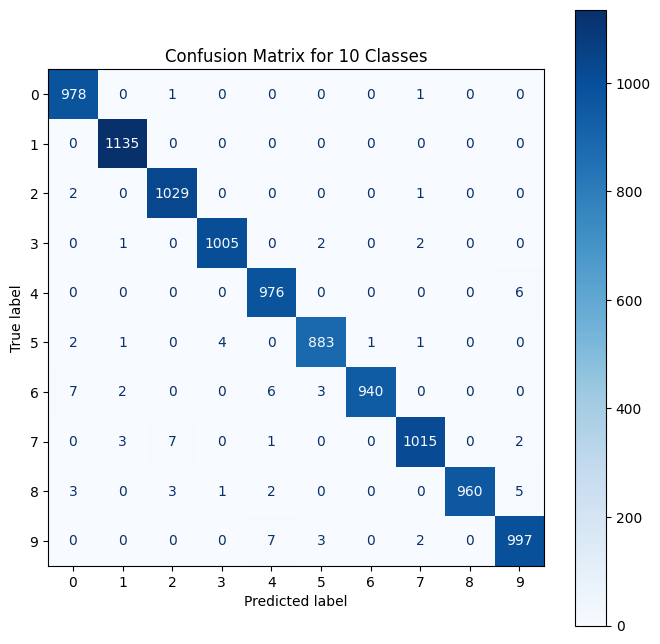

Batch Size: 32
Number of Epochs: 10
Learning Rate (starting): 0.0001
Epoch: [1/10], Loss: 0.0051
Epoch: [2/10], Loss: 0.0021
Epoch: [3/10], Loss: 0.0015
Epoch: [4/10], Loss: 0.0009
Epoch: [5/10], Loss: 0.0007
Epoch: [6/10], Loss: 0.0006
Epoch: [7/10], Loss: 0.0006
Epoch: [8/10], Loss: 0.0005
Epoch: [9/10], Loss: 0.0003
Epoch: [10/10], Loss: 0.0003
Latency : 0.0006301403045654297, Cpu Usage : 0.0
Latency : 0.0003986358642578125, Cpu Usage : 0.0
Latency : 0.0003972053527832031, Cpu Usage : 0.0
Latency : 0.0004551410675048828, Cpu Usage : 0.0
Latency : 0.00039386749267578125, Cpu Usage : 0.0
Latency : 0.0003883838653564453, Cpu Usage : 0.0
Latency : 0.0003838539123535156, Cpu Usage : 0.0
Latency : 0.0006442070007324219, Cpu Usage : 0.0
Latency : 0.00043082237243652344, Cpu Usage : 0.0
Latency : 0.0005812644958496094, Cpu Usage : 0.0
Latency : 0.0003960132598876953, Cpu Usage : 0.0
Latency : 0.0004456043243408203, Cpu Usage : 0.0
Latency : 0.00045180320739746094, Cpu Usage : 0.0
Latency : 

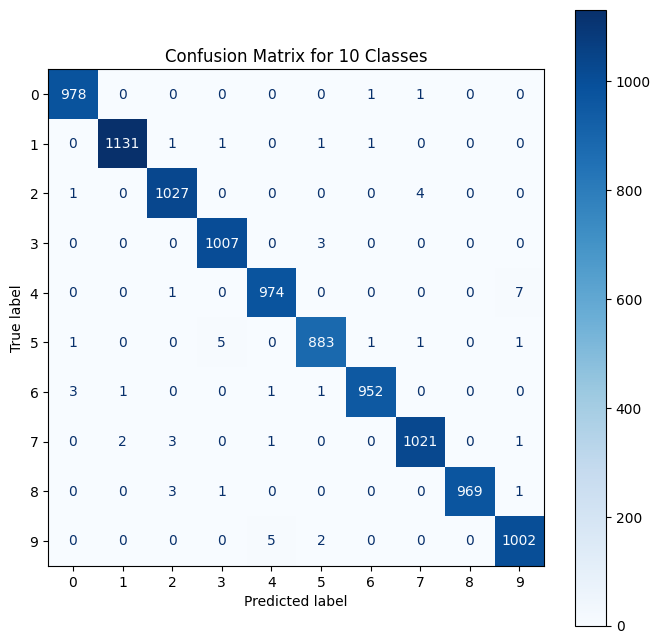

Batch Size: 32
Number of Epochs: 50
Learning Rate (starting): 0.001
Epoch: [1/50], Loss: 0.0085
Epoch: [2/50], Loss: 0.0099
Epoch: [3/50], Loss: 0.0083
Epoch: [4/50], Loss: 0.0081
Epoch: [5/50], Loss: 0.0078
Epoch: [6/50], Loss: 0.0065
Epoch: [7/50], Loss: 0.0078
Epoch: [8/50], Loss: 0.0069
Epoch: [9/50], Loss: 0.0061
Epoch: [10/50], Loss: 0.0059
Epoch: [11/50], Loss: 0.0064
Epoch: [12/50], Loss: 0.0061
Epoch: [13/50], Loss: 0.0064
Epoch: [14/50], Loss: 0.0046
Epoch: [15/50], Loss: 0.0051
Epoch: [16/50], Loss: 0.0048
Epoch: [17/50], Loss: 0.0044
Epoch: [18/50], Loss: 0.0046
Epoch: [19/50], Loss: 0.0055
Epoch: [20/50], Loss: 0.0041
Epoch: [21/50], Loss: 0.0060
Epoch: [22/50], Loss: 0.0035
Epoch: [23/50], Loss: 0.0052
Epoch: [24/50], Loss: 0.0041
Epoch: [25/50], Loss: 0.0046
Epoch: [26/50], Loss: 0.0044
Epoch: [27/50], Loss: 0.0036
Epoch: [28/50], Loss: 0.0040
Epoch: [29/50], Loss: 0.0042
Epoch: [30/50], Loss: 0.0030
Epoch: [31/50], Loss: 0.0042
Epoch: [32/50], Loss: 0.0028
Epoch: [33/50

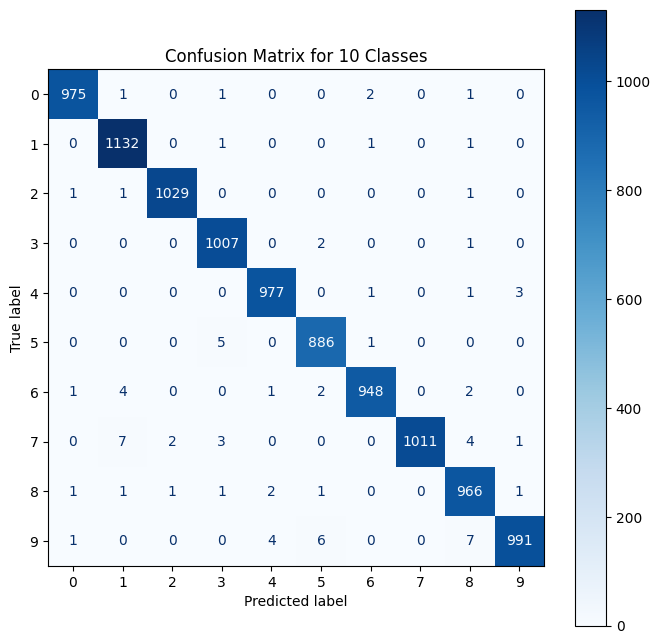

Batch Size: 32
Number of Epochs: 50
Learning Rate (starting): 0.0001
Epoch: [1/50], Loss: 0.0015
Epoch: [2/50], Loss: 0.0007
Epoch: [3/50], Loss: 0.0004
Epoch: [4/50], Loss: 0.0002
Epoch: [5/50], Loss: 0.0002
Epoch: [6/50], Loss: 0.0002
Epoch: [7/50], Loss: 0.0001
Epoch: [8/50], Loss: 0.0002
Epoch: [9/50], Loss: 0.0001
Epoch: [10/50], Loss: 0.0001
Epoch: [11/50], Loss: 0.0001
Epoch: [12/50], Loss: 0.0001
Epoch: [13/50], Loss: 0.0001
Epoch: [14/50], Loss: 0.0000
Epoch: [15/50], Loss: 0.0001
Epoch: [16/50], Loss: 0.0000
Epoch: [17/50], Loss: 0.0000
Epoch: [18/50], Loss: 0.0000
Epoch: [19/50], Loss: 0.0001
Epoch: [20/50], Loss: 0.0000
Epoch: [21/50], Loss: 0.0002
Epoch: [22/50], Loss: 0.0000
Epoch: [23/50], Loss: 0.0000
Epoch: [24/50], Loss: 0.0000
Epoch: [25/50], Loss: 0.0000
Epoch: [26/50], Loss: 0.0000
Epoch: [27/50], Loss: 0.0000
Epoch: [28/50], Loss: 0.0001
Epoch: [29/50], Loss: 0.0000
Epoch: [30/50], Loss: 0.0000
Epoch: [31/50], Loss: 0.0000
Epoch: [32/50], Loss: 0.0000
Epoch: [33/5

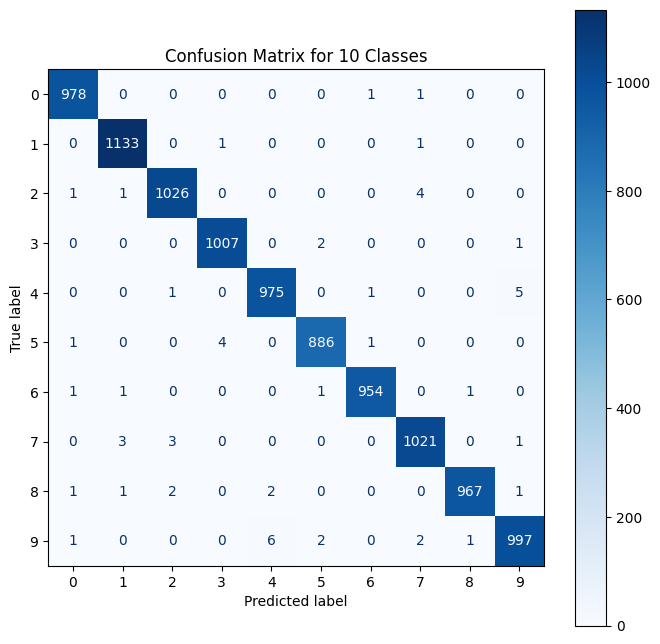

Batch Size: 32
Number of Epochs: 100
Learning Rate (starting): 0.001
Epoch: [1/100], Loss: 0.0047
Epoch: [2/100], Loss: 0.0025
Epoch: [3/100], Loss: 0.0031
Epoch: [4/100], Loss: 0.0039
Epoch: [5/100], Loss: 0.0032
Epoch: [6/100], Loss: 0.0029
Epoch: [7/100], Loss: 0.0027
Epoch: [8/100], Loss: 0.0020
Epoch: [9/100], Loss: 0.0029
Epoch: [10/100], Loss: 0.0032
Epoch: [11/100], Loss: 0.0036
Epoch: [12/100], Loss: 0.0023
Epoch: [13/100], Loss: 0.0034
Epoch: [14/100], Loss: 0.0021
Epoch: [15/100], Loss: 0.0027
Epoch: [16/100], Loss: 0.0034
Epoch: [17/100], Loss: 0.0042
Epoch: [18/100], Loss: 0.0017
Epoch: [19/100], Loss: 0.0034
Epoch: [20/100], Loss: 0.0027
Epoch: [21/100], Loss: 0.0026
Epoch: [22/100], Loss: 0.0040
Epoch: [23/100], Loss: 0.0022
Epoch: [24/100], Loss: 0.0022
Epoch: [25/100], Loss: 0.0044
Epoch: [26/100], Loss: 0.0016
Epoch: [27/100], Loss: 0.0055
Epoch: [28/100], Loss: 0.0020
Epoch: [29/100], Loss: 0.0029
Epoch: [30/100], Loss: 0.0036
Epoch: [31/100], Loss: 0.0015
Epoch: [32

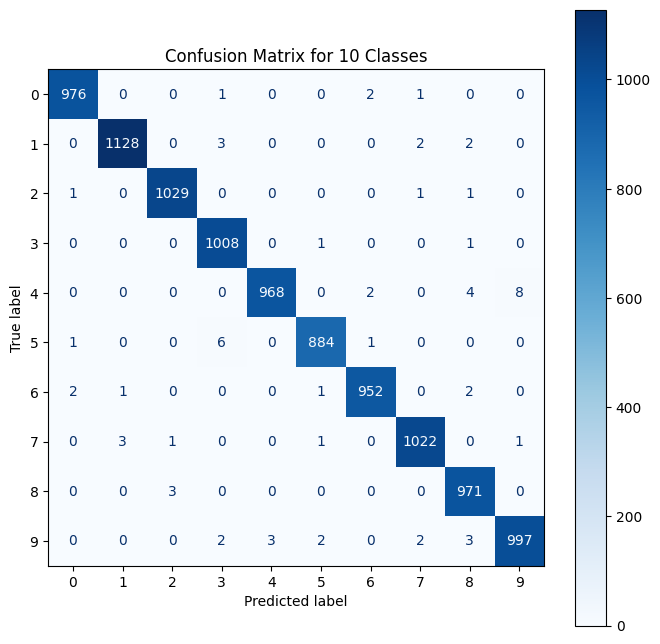

Batch Size: 32
Number of Epochs: 100
Learning Rate (starting): 0.0001
Epoch: [1/100], Loss: 0.0014
Epoch: [2/100], Loss: 0.0002
Epoch: [3/100], Loss: 0.0001
Epoch: [4/100], Loss: 0.0002
Epoch: [5/100], Loss: 0.0003
Epoch: [6/100], Loss: 0.0003
Epoch: [7/100], Loss: 0.0001
Epoch: [8/100], Loss: 0.0005
Epoch: [9/100], Loss: 0.0001
Epoch: [10/100], Loss: 0.0001
Epoch: [11/100], Loss: 0.0001
Epoch: [12/100], Loss: 0.0000
Epoch: [13/100], Loss: 0.0001
Epoch: [14/100], Loss: 0.0000
Epoch: [15/100], Loss: 0.0000
Epoch: [16/100], Loss: 0.0000
Epoch: [17/100], Loss: 0.0001
Epoch: [18/100], Loss: 0.0000
Epoch: [19/100], Loss: 0.0000
Epoch: [20/100], Loss: 0.0000
Epoch: [21/100], Loss: 0.0001
Epoch: [22/100], Loss: 0.0001
Epoch: [23/100], Loss: 0.0002
Epoch: [24/100], Loss: 0.0000
Epoch: [25/100], Loss: 0.0000
Epoch: [26/100], Loss: 0.0000
Epoch: [27/100], Loss: 0.0001
Epoch: [28/100], Loss: 0.0001
Epoch: [29/100], Loss: 0.0000
Epoch: [30/100], Loss: 0.0000
Epoch: [31/100], Loss: 0.0000
Epoch: [3

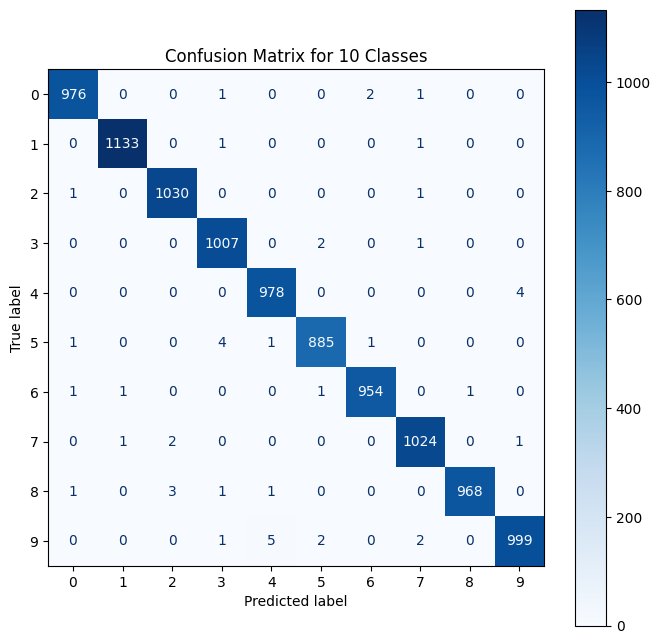

Batch Size: 64
Number of Epochs: 10
Learning Rate (starting): 0.001
Epoch: [1/10], Loss: 0.0001
Epoch: [2/10], Loss: 0.0033
Epoch: [3/10], Loss: 0.0017
Epoch: [4/10], Loss: 0.0011
Epoch: [5/10], Loss: 0.0012
Epoch: [6/10], Loss: 0.0025
Epoch: [7/10], Loss: 0.0009
Epoch: [8/10], Loss: 0.0008
Epoch: [9/10], Loss: 0.0028
Epoch: [10/10], Loss: 0.0023
Latency : 0.0006139278411865234, Cpu Usage : 0.0
Latency : 0.0006988048553466797, Cpu Usage : 0.0
Latency : 0.0006046295166015625, Cpu Usage : 0.0
Latency : 0.0006213188171386719, Cpu Usage : 0.0
Latency : 0.0005612373352050781, Cpu Usage : 0.0
Latency : 0.0007088184356689453, Cpu Usage : 0.0
Latency : 0.0006380081176757812, Cpu Usage : 0.0
Latency : 0.0006580352783203125, Cpu Usage : 0.0
Latency : 0.0006570816040039062, Cpu Usage : 0.0
Latency : 0.0007212162017822266, Cpu Usage : 0.0
Latency : 0.0006954669952392578, Cpu Usage : 0.0
Latency : 0.0006279945373535156, Cpu Usage : 1462.5
Latency : 0.0005857944488525391, Cpu Usage : 0.0
Latency : 0

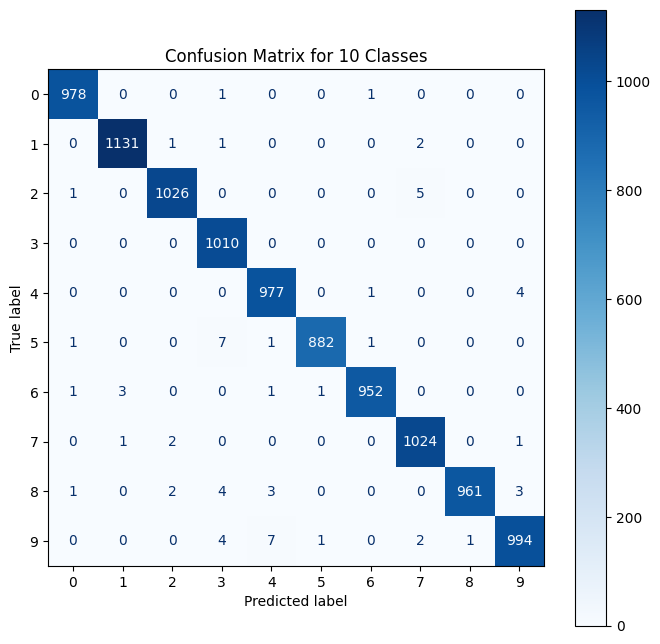

Batch Size: 64
Number of Epochs: 10
Learning Rate (starting): 0.0001
Epoch: [1/10], Loss: 0.0008
Epoch: [2/10], Loss: 0.0000
Epoch: [3/10], Loss: 0.0001
Epoch: [4/10], Loss: 0.0001
Epoch: [5/10], Loss: 0.0002
Epoch: [6/10], Loss: 0.0003
Epoch: [7/10], Loss: 0.0001
Epoch: [8/10], Loss: 0.0000
Epoch: [9/10], Loss: 0.0001
Epoch: [10/10], Loss: 0.0001
Latency : 0.0005965232849121094, Cpu Usage : 0.0
Latency : 0.0005896091461181641, Cpu Usage : 0.0
Latency : 0.0007917881011962891, Cpu Usage : 0.0
Latency : 0.00066375732421875, Cpu Usage : 0.0
Latency : 0.0006291866302490234, Cpu Usage : 0.0
Latency : 0.0006182193756103516, Cpu Usage : 0.0
Latency : 0.0006489753723144531, Cpu Usage : 0.0
Latency : 0.0006005764007568359, Cpu Usage : 0.0
Latency : 0.0005657672882080078, Cpu Usage : 0.0
Latency : 0.0006346702575683594, Cpu Usage : 0.0
Latency : 0.0005490779876708984, Cpu Usage : 0.0
Latency : 0.0006210803985595703, Cpu Usage : 0.0
Latency : 0.0006346702575683594, Cpu Usage : 0.0
Latency : 0.000

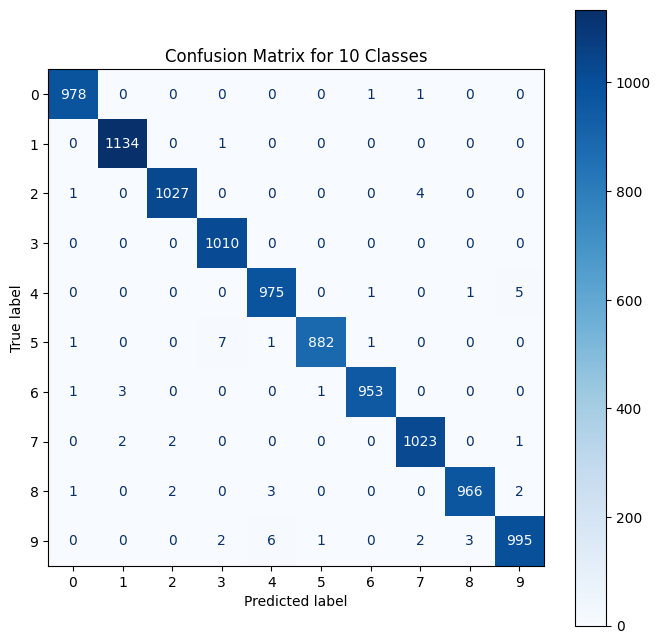

Batch Size: 64
Number of Epochs: 50
Learning Rate (starting): 0.001
Epoch: [1/50], Loss: 0.0019
Epoch: [2/50], Loss: 0.0006
Epoch: [3/50], Loss: 0.0009
Epoch: [4/50], Loss: 0.0021
Epoch: [5/50], Loss: 0.0017
Epoch: [6/50], Loss: 0.0008
Epoch: [7/50], Loss: 0.0016
Epoch: [8/50], Loss: 0.0012
Epoch: [9/50], Loss: 0.0016
Epoch: [10/50], Loss: 0.0029
Epoch: [11/50], Loss: 0.0015
Epoch: [12/50], Loss: 0.0014
Epoch: [13/50], Loss: 0.0034
Epoch: [14/50], Loss: 0.0006
Epoch: [15/50], Loss: 0.0013
Epoch: [16/50], Loss: 0.0010
Epoch: [17/50], Loss: 0.0009
Epoch: [18/50], Loss: 0.0012
Epoch: [19/50], Loss: 0.0010
Epoch: [20/50], Loss: 0.0021
Epoch: [21/50], Loss: 0.0022
Epoch: [22/50], Loss: 0.0007
Epoch: [23/50], Loss: 0.0013
Epoch: [24/50], Loss: 0.0009
Epoch: [25/50], Loss: 0.0015
Epoch: [26/50], Loss: 0.0009
Epoch: [27/50], Loss: 0.0011
Epoch: [28/50], Loss: 0.0029
Epoch: [29/50], Loss: 0.0021
Epoch: [30/50], Loss: 0.0014
Epoch: [31/50], Loss: 0.0016
Epoch: [32/50], Loss: 0.0005
Epoch: [33/50

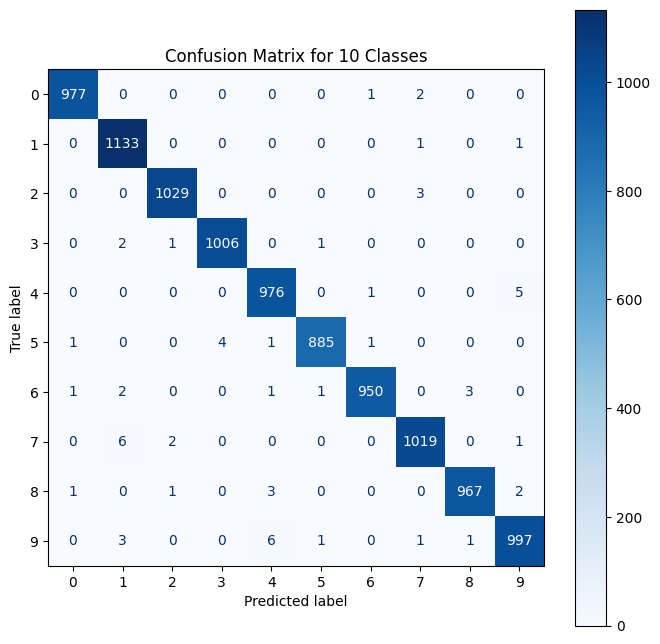

Batch Size: 64
Number of Epochs: 50
Learning Rate (starting): 0.0001
Epoch: [1/50], Loss: 0.0008
Epoch: [2/50], Loss: 0.0002
Epoch: [3/50], Loss: 0.0003
Epoch: [4/50], Loss: 0.0003
Epoch: [5/50], Loss: 0.0003
Epoch: [6/50], Loss: 0.0005
Epoch: [7/50], Loss: 0.0001
Epoch: [8/50], Loss: 0.0003
Epoch: [9/50], Loss: 0.0001
Epoch: [10/50], Loss: 0.0001
Epoch: [11/50], Loss: 0.0000
Epoch: [12/50], Loss: 0.0001
Epoch: [13/50], Loss: 0.0001
Epoch: [14/50], Loss: 0.0000
Epoch: [15/50], Loss: 0.0000
Epoch: [16/50], Loss: 0.0001
Epoch: [17/50], Loss: 0.0002
Epoch: [18/50], Loss: 0.0002
Epoch: [19/50], Loss: 0.0000
Epoch: [20/50], Loss: 0.0002
Epoch: [21/50], Loss: 0.0000
Epoch: [22/50], Loss: 0.0000
Epoch: [23/50], Loss: 0.0002
Epoch: [24/50], Loss: 0.0000
Epoch: [25/50], Loss: 0.0003
Epoch: [26/50], Loss: 0.0001
Epoch: [27/50], Loss: 0.0000
Epoch: [28/50], Loss: 0.0000
Epoch: [29/50], Loss: 0.0000
Epoch: [30/50], Loss: 0.0002
Epoch: [31/50], Loss: 0.0001
Epoch: [32/50], Loss: 0.0001
Epoch: [33/5

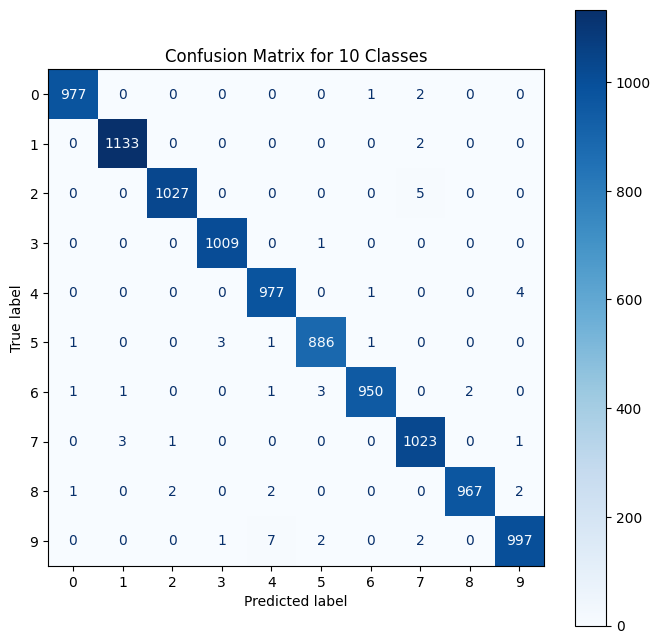

Batch Size: 64
Number of Epochs: 100
Learning Rate (starting): 0.001
Epoch: [1/100], Loss: 0.0004
Epoch: [2/100], Loss: 0.0016
Epoch: [3/100], Loss: 0.0015
Epoch: [4/100], Loss: 0.0006
Epoch: [5/100], Loss: 0.0013
Epoch: [6/100], Loss: 0.0025
Epoch: [7/100], Loss: 0.0004
Epoch: [8/100], Loss: 0.0003
Epoch: [9/100], Loss: 0.0025
Epoch: [10/100], Loss: 0.0019
Epoch: [11/100], Loss: 0.0016
Epoch: [12/100], Loss: 0.0024
Epoch: [13/100], Loss: 0.0014
Epoch: [14/100], Loss: 0.0005
Epoch: [15/100], Loss: 0.0006
Epoch: [16/100], Loss: 0.0026
Epoch: [17/100], Loss: 0.0018
Epoch: [18/100], Loss: 0.0007
Epoch: [19/100], Loss: 0.0015
Epoch: [20/100], Loss: 0.0009
Epoch: [21/100], Loss: 0.0003
Epoch: [22/100], Loss: 0.0014
Epoch: [23/100], Loss: 0.0007
Epoch: [24/100], Loss: 0.0005
Epoch: [25/100], Loss: 0.0010
Epoch: [26/100], Loss: 0.0016
Epoch: [27/100], Loss: 0.0020
Epoch: [28/100], Loss: 0.0018
Epoch: [29/100], Loss: 0.0020
Epoch: [30/100], Loss: 0.0019
Epoch: [31/100], Loss: 0.0023
Epoch: [32

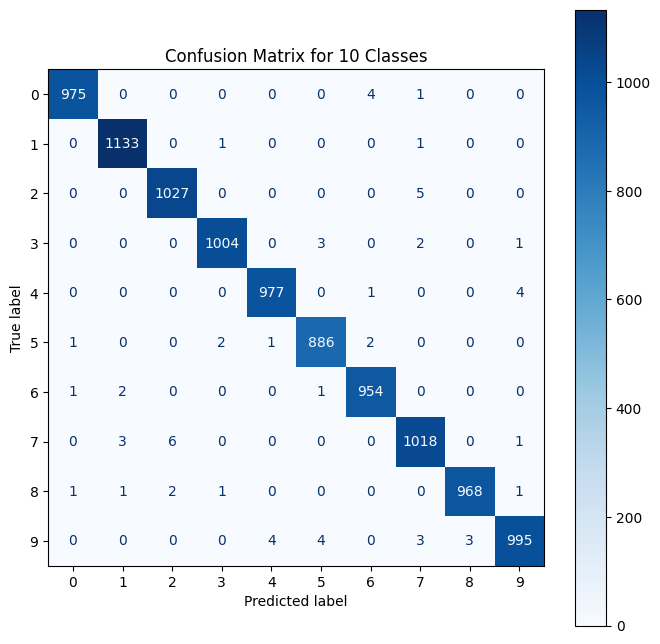

Batch Size: 64
Number of Epochs: 100
Learning Rate (starting): 0.0001
Epoch: [1/100], Loss: 0.0013
Epoch: [2/100], Loss: 0.0004
Epoch: [3/100], Loss: 0.0006
Epoch: [4/100], Loss: 0.0003
Epoch: [5/100], Loss: 0.0003
Epoch: [6/100], Loss: 0.0002
Epoch: [7/100], Loss: 0.0006
Epoch: [8/100], Loss: 0.0003
Epoch: [9/100], Loss: 0.0001
Epoch: [10/100], Loss: 0.0001
Epoch: [11/100], Loss: 0.0000
Epoch: [12/100], Loss: 0.0001
Epoch: [13/100], Loss: 0.0000
Epoch: [14/100], Loss: 0.0001
Epoch: [15/100], Loss: 0.0001
Epoch: [16/100], Loss: 0.0001
Epoch: [17/100], Loss: 0.0002
Epoch: [18/100], Loss: 0.0001
Epoch: [19/100], Loss: 0.0001
Epoch: [20/100], Loss: 0.0001
Epoch: [21/100], Loss: 0.0002
Epoch: [22/100], Loss: 0.0000
Epoch: [23/100], Loss: 0.0000
Epoch: [24/100], Loss: 0.0004
Epoch: [25/100], Loss: 0.0001
Epoch: [26/100], Loss: 0.0005
Epoch: [27/100], Loss: 0.0000
Epoch: [28/100], Loss: 0.0001
Epoch: [29/100], Loss: 0.0000
Epoch: [30/100], Loss: 0.0002
Epoch: [31/100], Loss: 0.0000
Epoch: [3

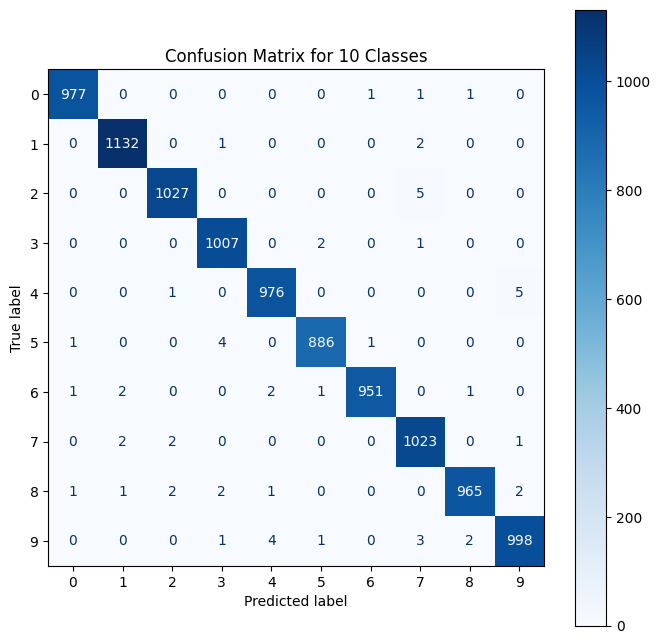

In [8]:
batch_sizes = [32,64]
num_epochs = [10,50,100]
learning_rate = [0.001,0.0001]
data = []
for batch_size in batch_sizes:
    for epochs in num_epochs:
        for lr in learning_rate:
            
            train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
            test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
            latency = train_model(model,device,train_loader,lr,epochs)
            accuracy,predictedLabels,trueLabels = test_model(test_loader,model,device=device)
            
            cm = confusion_matrix(trueLabels, predictedLabels)
            fig, ax = plt.subplots(figsize=(8,8))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=range(10))
            disp.plot(ax=ax, cmap='Blues', colorbar=True)
            plt.title("Confusion Matrix for 10 Classes")
            plt.show()
            
            f1_score_data = f1_score(trueLabels, predictedLabels,average="macro")
            data.append({
                "batch_size":batch_size,    
                "learning_rate":lr,
                "epochs":epochs,
                "accuracy":accuracy,
                "f1_score":f1_score_data,
                "latency":latency
            })

In [9]:
data

[{'batch_size': 32,
  'learning_rate': 0.001,
  'epochs': 10,
  'accuracy': 99.18,
  'f1_score': 0.9917042947407898,
  'latency': None},
 {'batch_size': 32,
  'learning_rate': 0.0001,
  'epochs': 10,
  'accuracy': 99.44,
  'f1_score': 0.9943483205483155,
  'latency': None},
 {'batch_size': 32,
  'learning_rate': 0.001,
  'epochs': 50,
  'accuracy': 99.22,
  'f1_score': 0.9921599447048204,
  'latency': None},
 {'batch_size': 32,
  'learning_rate': 0.0001,
  'epochs': 50,
  'accuracy': 99.44,
  'f1_score': 0.9943832577687202,
  'latency': None},
 {'batch_size': 32,
  'learning_rate': 0.001,
  'epochs': 100,
  'accuracy': 99.35,
  'f1_score': 0.9934601789228727,
  'latency': None},
 {'batch_size': 32,
  'learning_rate': 0.0001,
  'epochs': 100,
  'accuracy': 99.54,
  'f1_score': 0.9953442644182932,
  'latency': None},
 {'batch_size': 64,
  'learning_rate': 0.001,
  'epochs': 10,
  'accuracy': 99.35,
  'f1_score': 0.9934677428801457,
  'latency': None},
 {'batch_size': 64,
  'learning_rate

# performing image augmentations

In [10]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomCrop(32, padding=4),   # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color adjustments
    transforms.RandomRotation(15),         # Random rotation within 15 degrees
    transforms.ToTensor(),                 # Convert to tensor
        transforms.Resize((28,28)),    
  transforms.Normalize((0.5,), (0.5,))
])

# Test data transformations (no augmentation)
test_transforms = transforms.Compose([
        transforms.Resize((28,28)),    
    transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='./data', train=True, transform=train_transforms, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=test_transforms, download=True)

Batch Size: 16
Number of Epochs: 10
Learning Rate (starting): 0.001
Epoch: [1/10], Loss: 0.6850
Epoch: [2/10], Loss: 0.2563
Epoch: [3/10], Loss: 0.1924
Epoch: [4/10], Loss: 0.1611
Epoch: [5/10], Loss: 0.1415
Epoch: [6/10], Loss: 0.1277
Epoch: [7/10], Loss: 0.1177
Epoch: [8/10], Loss: 0.1087
Epoch: [9/10], Loss: 0.1028
Epoch: [10/10], Loss: 0.1013
Latency : 0.00048661231994628906, Cpu Usage : 1875.6
Latency : 0.000385284423828125, Cpu Usage : 0.0
Latency : 0.00037407875061035156, Cpu Usage : 0.0
Latency : 0.00036644935607910156, Cpu Usage : 0.0
Latency : 0.00041484832763671875, Cpu Usage : 0.0
Latency : 0.00038886070251464844, Cpu Usage : 0.0
Latency : 0.00036525726318359375, Cpu Usage : 0.0
Latency : 0.0003769397735595703, Cpu Usage : 0.0
Latency : 0.00036454200744628906, Cpu Usage : 0.0
Latency : 0.0003764629364013672, Cpu Usage : 0.0
Latency : 0.0003750324249267578, Cpu Usage : 0.0
Latency : 0.0003681182861328125, Cpu Usage : 0.0
Latency : 0.0004932880401611328, Cpu Usage : 0.0
Laten

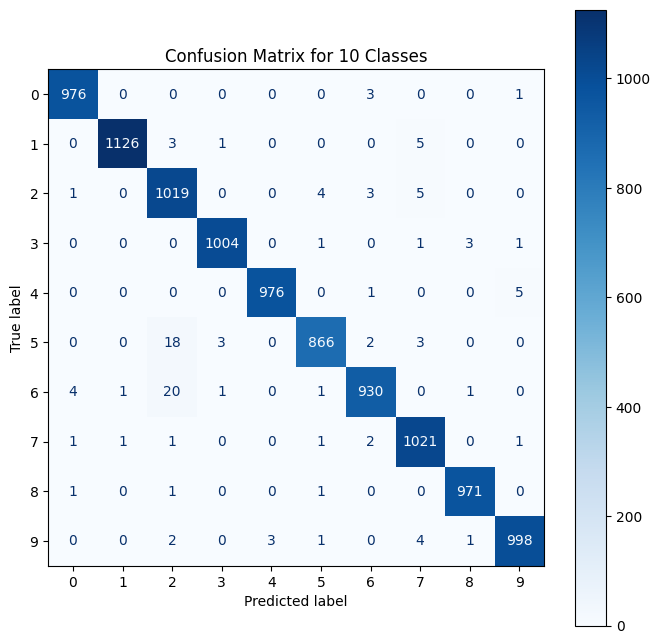

In [11]:
batch_sizes = [16,32,64,128]
num_epochs = [10,50,100]
learning_rate = [0.001,0.0001,0.00001]
aug_data = []
for batch_size in batch_sizes:
    for epochs in num_epochs:
        for lr in learning_rate:
            
            train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
            test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
            latency = train_model(model,device,train_loader,lr,epochs)
            accuracy,predictedLabels,trueLabels = test_model(test_loader,model,device=device)
            
            cm = confusion_matrix(trueLabels, predictedLabels)
            fig, ax = plt.subplots(figsize=(8,8))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=range(10))
            disp.plot(ax=ax, cmap='Blues', colorbar=True)
            plt.title("Confusion Matrix for 10 Classes")
            plt.show()
            
            f1_score_data = f1_score(trueLabels, predictedLabels,average="macro")
            aug_data.append({
                "batch_size":batch_size,
                "learning_rate":lr,
                "epochs":epochs,
                "accuracy":accuracy,
                "f1_score":f1_score_data
            })
            break
        break
    break

# adding tensor rt


In [12]:
import torch_tensorrt

/home/rohithk/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
import os
os.environ["TORCH_LOGS"] = "+dynamo"
os.environ["TORCHDYNAMO_VERBOSE"] = "1"


In [14]:
import torch
import torch_tensorrt

trt_module = torch_tensorrt.compile(
    model,
    inputs=[torch_tensorrt.Input((16, 1, 28, 28))],  
    enabled_precisions={torch_tensorrt.dtype.half}   
)

example_input = torch.randn(16, 1, 28, 28).cuda()  
scripted_trt_module = torch.jit.trace(trt_module, example_input)

torch.jit.save(scripted_trt_module, "trt_torchscript_module.ts")

In [15]:
import time
import torch
import torch_tensorrt
from torch.utils.data import DataLoader

loaded_module = torch.jit.load("trt_torchscript_module.ts")
loaded_module.eval() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_module = loaded_module.to(device)

total_time = 0
num_samples = 0
num_batches = 0

results = []
with torch.no_grad():  
    for inputs, labels in test_loader: 
        batch_size = inputs.size(0)
        inputs = inputs.to(device) 

        start_time = time.time()
        outputs = loaded_module(inputs) 
        end_time = time.time()

        batch_time = end_time - start_time
        total_time += batch_time
        num_samples += batch_size
        num_batches += 1

        results.append((outputs, labels)) 

latency_per_sample = (total_time / num_samples) * 1000  
average_latency_per_batch = (total_time / num_batches) * 1000  

print(f"Total Inference Time: {total_time:.2f} seconds")
print(f"Latency per Sample: {latency_per_sample:.2f} ms")
print(f"Average Latency per Batch: {average_latency_per_batch:.2f} ms")

correct = 0
total = 0
for outputs, labels in results:
    predictions = torch.argmax(outputs, dim=1)  
    correct += (predictions == labels.to(device)).sum().item()
    total += labels.size(0)

accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Total Inference Time: 0.09 seconds
Latency per Sample: 0.01 ms
Average Latency per Batch: 0.14 ms
Test Accuracy: 98.87%
